## Retrieval plots

In [4]:
import pandas as pd
from pathlib import Path
import numpy as np
import pickle
import yaml
from mist.utils.plot_utils import *
from mist.utils import analysis_utils 

from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
from collections import Counter

# reload analysis_utils
from importlib import reload
reload(analysis_utils)

set_style()

In [5]:
out_folder = Path("../results/figures/canopus_retrieval_compare/")
out_folder.mkdir(parents=True, exist_ok=True)

output_entries = [
    {"model": "mist", 
    "retrieval": "contrastive", 
    "file": "../results/canopus_retrieval_compare/mist_contrastive_retrieval/canopus_hplus_100_0/retrieval_contrastive_intpubchem_with_morgan4096_retrieval_db_canopus_train_cosine_analysis.yaml"}, 

    {"model": "mist", 
    "retrieval": "fp", 
    "file": "../results/canopus_retrieval_compare/mist_fp_retrieval/canopus_hplus_100_0/retrieval_fp_intpubchem_with_morgan4096_retrieval_db_canopus_train_cosine_analysis.yaml"},
    
    {"model": "ffn", 
    "retrieval": "fp", 
    "file": "../results/canopus_retrieval_compare/ffn_fp_retrieval/canopus_hplus_100_0/retrieval_fp_intpubchem_with_morgan4096_retrieval_db_canopus_train_cosine_analysis.yaml"},

]

In [6]:
full_res = []
for i in output_entries:
    # yaml read 
    res_file = i['file']
    # Load yaml 
    res_obj = yaml.load(open(res_file, 'r'), Loader=yaml.FullLoader)
    fold = Path(res_file).parent.name
    for j in res_obj['individuals']: 
        j['file'] = res_file
        j['model'] = i['model']
        j['retrieval'] = i['retrieval']
        full_res.append(j)
full_df = pd.DataFrame(full_res)

In [7]:
# Ind found max 
is_na = pd.isna(full_df['ind_found'])
full_df.loc[is_na, 'ind_found'] = 1e10

# Sanity check
Counter(full_df.groupby("name").count()['ind_found'].values)

Counter({3: 819})

## Retrieval accuracy table

In [8]:
# group full df by 'retrieval' and 'model' 
# Then for each category, compute 5 different functions to get top k accuracy at k = 1, 2, 5, 10, 20 over ind_found

# Apply each fn to each group
new_cols = [] 
for k in range(1, 300):
    fn = lambda x: (x['ind_found'] <= k).mean()
    new_vals = full_df.groupby(['retrieval', 'model']).apply(fn)
    # Rename columns
    new_vals = new_vals.rename("Accuracy").reset_index()
    new_vals['k'] = k
    new_cols.append(new_vals)

# Concat
full_ac  = pd.concat(new_cols, axis=0)

display_ks = [1, 2, 5, 10, 20, 50, 100, 200]
display_ac = full_ac[full_ac['k'].isin(display_ks)]

# Pivot into two indices, columns are k
display_ac = display_ac.pivot(index=['model', 'retrieval'], columns='k', values='Accuracy').round(3)
display(display_ac)

# To latex
latex_tbl = display_ac.to_latex(float_format="%.3f", caption="Retrieval accuracy against CSI")
print(latex_tbl)
with open(out_folder / f"retrieval_acc_table.tex", "w") as fp:
    fp.write(latex_tbl)



k                    1      2      5      10     20     50     100    200
model retrieval                                                          
ffn   fp           0.133  0.195  0.288  0.375  0.444  0.509  0.556  0.607
mist  contrastive  0.215  0.344  0.479  0.563  0.623  0.686  0.717  0.731
      fp           0.203  0.314  0.411  0.490  0.551  0.617  0.667  0.698

\begin{table}
\centering
\caption{Retrieval accuracy against CSI}
\begin{tabular}{llrrrrrrrr}
\toprule
     & k &   1   &   2   &   5   &   10  &   20  &   50  &   100 &   200 \\
model & retrieval &       &       &       &       &       &       &       &       \\
\midrule
ffn & fp & 0.133 & 0.195 & 0.288 & 0.375 & 0.444 & 0.509 & 0.556 & 0.607 \\
mist & contrastive & 0.215 & 0.344 & 0.479 & 0.563 & 0.623 & 0.686 & 0.717 & 0.731 \\
     & fp & 0.203 & 0.314 & 0.411 & 0.490 & 0.551 & 0.617 & 0.667 & 0.698 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_65979/276399748.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_tbl = display_ac.to_latex(float_format="%.3f", caption="Retrieval accuracy against CSI")


## Create lineplots

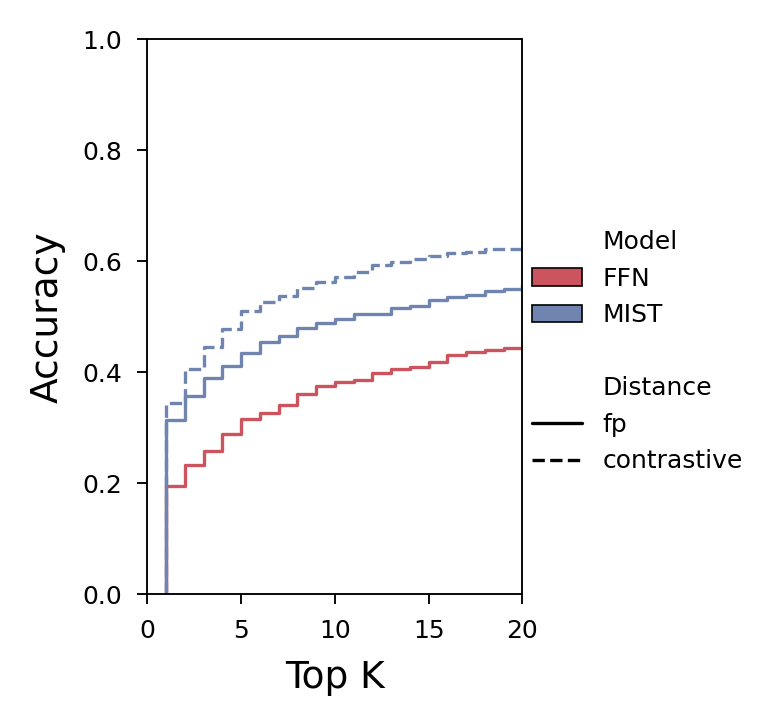

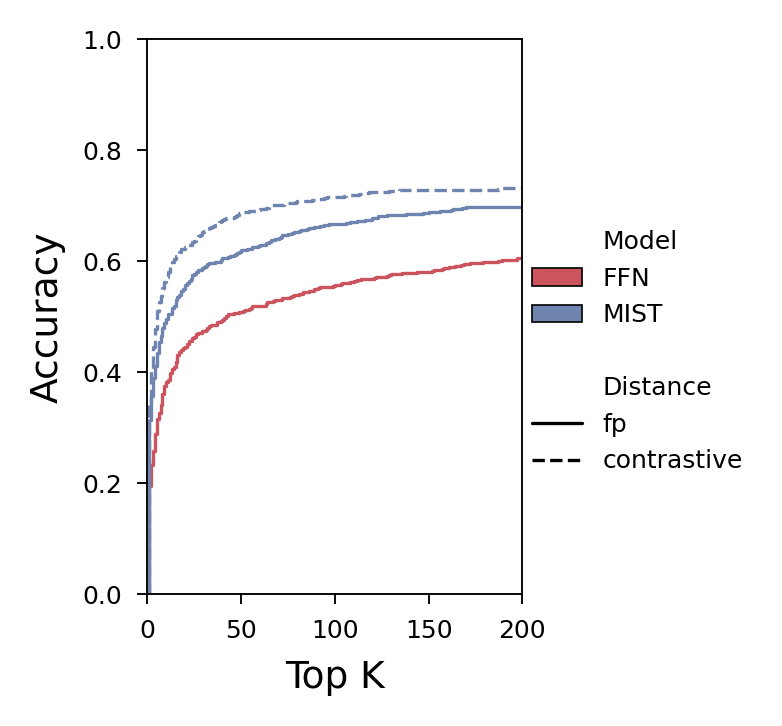

In [9]:
plots = [{"outname": out_folder / "csi_lineplot_20.pdf",
          "x_max": 20},
         {"outname": out_folder / "csi_lineplot_200.pdf",
          "x_max": 200}]

ax_figsize = (1.25, 1.85)
used_styles = set()
used_methods = set()

for plot in plots:
    outname = plot["outname"]
    x_max = plot["x_max"]
    fig = plt.figure(figsize=(ax_figsize), dpi=300)
    ax = fig.gca()
    for (model, retrieval), subdf in full_ac.groupby(["model", "retrieval"]):
        color = color_scheme[model]
        linestyle = line_scheme[retrieval]
        method_name = method_rename[model]
        line_name = line_rename[retrieval]
        # sort subdf by k
        subdf = subdf.sort_values(by="k")
        x = [1, *subdf['k'].values]
        y = [0, *subdf['Accuracy'].values]
        ax.step(x[0:], y[0:], c=color,
                linestyle=linestyle, linewidth=0.8)
        used_methods.add(model)
        used_styles.add(retrieval)

    # Build legend
    patch_legend_handles = [
        Patch(facecolor=color_scheme[model],
              label=method_rename[model], edgecolor="black", linewidth=0.4,)
        for model in color_scheme.keys()
        if model in used_methods
    ]
    patch_legend_handles.append(
        Rectangle((0, 0), 1, 1, fill=False, edgecolor="none", visible=False)
    )
    patch_legend_handles.insert(
        0,
        Rectangle(
            (0, 0), 1, 1, fill=False, edgecolor="none", visible=False, label="Model"
        ),
    )
    line_legend_handles = [
        Line2D(
            [0, 1],
            [0, 1],
            linestyle=line_scheme[style],
            linewidth=0.8,
            color="black",
            label=style,
        )
        for style in line_scheme.keys()
        if style in used_styles
    ]
    line_legend_handles.insert(
        0,
        Rectangle(
            (0, 0), 1, 1, fill=False, edgecolor="none", visible=False, label="Distance"
        ),
    )
    legend_handles = [*patch_legend_handles, *line_legend_handles]
    legend = ax.legend(
        handles=legend_handles,
        # add loc to right of plot just outside
        loc=(1.0, 0.2),

        frameon=False,
        facecolor="none",
        fancybox=False,  # ncol=2,
        columnspacing=0.5,
    )


    ax.set_xlim([0, x_max])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel("Top K")
    ax.set_ylabel("Accuracy")
    set_size(*ax_figsize)
    fig.savefig(outname, bbox_inches="tight", dpi=400, transparent=True)


## Create barplot

In [10]:
cls_annots = "../results/dataset_analyses/csi2022/smi_to_classes.p"
cls_annots = pickle.load(open(cls_annots, "rb"))

In [11]:
full_df['joint_method'] = full_df['model'] + '_' + full_df['retrieval']
sub_df = full_df[full_df['joint_method'].isin(['mist_contrastive', 'sirius_bayes'])].reset_index(drop=True)

In [12]:
row_tbl = sub_df.pivot_table(
    index="name", columns="joint_method", values="ind_found", aggfunc="first"
)

In [13]:
# Now get chem classes on each row
new_df = []
superclasses = [cls_annots[i]["superclass_results"] for i in row_tbl.index]
for row_ind, superclasses in enumerate(superclasses):
    for superclass in superclasses:
        # Get dataseet row into dict form; use only second column
        row_dict = row_tbl.iloc[row_ind].to_dict()
        row_dict = {k: v for k,v in row_dict.items()}
        row_dict["Superclass"] = superclass
        row_dict['spec'] = row_tbl.index.values[row_ind]
        new_df.append(row_dict)
row_tbl_cls = pd.DataFrame(new_df)

KeyError: 'CCMSLIB00000005397'

In [ ]:
method_1 = "mist_contrastive"
method_2 = "sirius_bayes"
compare_df = []
for sclass, row in row_tbl_cls.groupby("Superclass"):
    ours_better = row[method_1] < row[method_2]
    theirs_better = row[method_2] < row[method_1]
    same = row[method_1] == row[method_2]
    compare_df.append({
        "Superclass": sclass,
        "ours_better": ours_better.sum(),
        "theirs_better": theirs_better.sum(),
        "same": same.sum(),
        "total": len(row),
    })
compare_df = pd.DataFrame(compare_df)
compare_df["ours_frac"] = compare_df["ours_better"] / compare_df["total"] * 100
compare_df["theirs_frac"] = compare_df["theirs_better"] / compare_df["total"] * 100 
compare_df["same_frac"] = compare_df["same"] / compare_df["total"] * 100
compare_df = compare_df.sort_values("ours_frac", ascending=False)

In [ ]:
# Filter to only num > 20 total
compare_df = compare_df[compare_df["total"] > 20]

In [ ]:
ours_col = color_scheme['mist']
them_col = color_scheme['sirius']
same_col = "#DFE1EC"

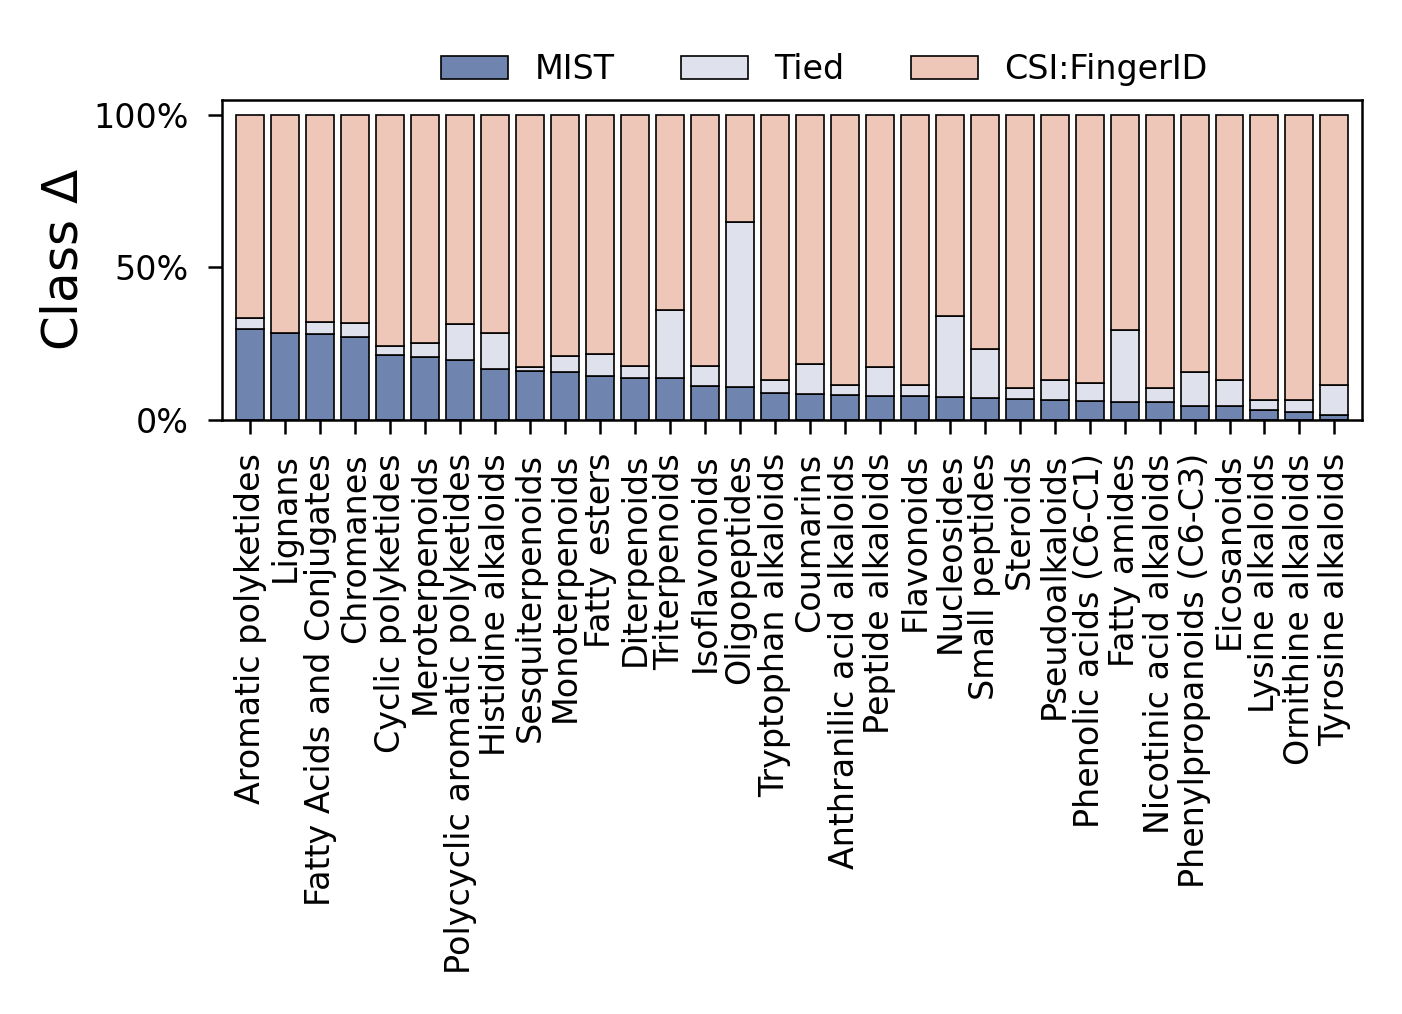

In [ ]:
save_name = out_folder / f"retrieval_cls_barplot.pdf"
ax_sizes = (2.85, 0.8)
fig = plt.figure(figsize=ax_sizes, dpi=400)
ax = fig.gca()
same, them, us = (
    compare_df["same_frac"].values,
    compare_df["theirs_frac"].values,
    compare_df["ours_frac"].values,
)
x = compare_df["Superclass"].values
x = [xx.strip() for xx in x]
ax.bar(
    np.arange(len(x)),
    us,
    color=ours_col,
    edgecolor="black",
    linewidth=0.3,
    label=r"MIST",
)
ax.bar(
    np.arange(len(x)),
    same,
    bottom=us,
    color=same_col,
    edgecolor="black",
    label=r"Tied",
    linewidth=0.3,
)
ax.bar(
    np.arange(len(x)),
    them,
    color=them_col,
    edgecolor="black",
    linewidth=0.3,
    bottom=same + us,
    label=r"CSI:FingerID",
)

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation=90)
ax.set_xlim([-0.8, len(x) - 0.2])

fmt = "%.0f%%"
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.set_ylabel("Class $\Delta$", labelpad=1.0)

# ax.set_ylim([0,100]
# Re-assign second ax labels
set_size(*ax_sizes, ax)
ax.legend(frameon=False, facecolor="none", fancybox=False, ncol=3, loc=(0.18, 1.0))
fig.savefig(save_name, bbox_inches="tight",dpi=400, transparent=True)